In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import preprocess_string
import nltk
import json
import numpy as np
import gensim
from tqdm import tqdm
import pandas as pd
from sklearn import utils

In [2]:
f = open('../../data/train.json', 'rb')
train_data = json.load(f)

f = open('../../data/test.json', 'rb')
test_data = json.load(f)

In [3]:
train_sentence = []
train_label = []

test_sentence = []

for instance in train_data:
    sentence = []
    for i in instance['abstract']:
        sentence.append(str(i))
    for j in instance['title']:
        sentence.append(str(j))
    train_sentence.append(sentence)

    prolific_authors = [0 for _ in range(100)]
    for i in instance['authors']:
        if i < 100:
            prolific_authors[i] = 1
    train_label.append(prolific_authors)
    

for instance in test_data:
    sentence = []
    for i in instance['abstract']:
        sentence.append(str(i))
    for j in instance['title']:
        sentence.append(str(j))
    test_sentence.append(sentence)

In [4]:
train_df_all = pd.DataFrame({'text': train_sentence, 'label': train_label})

In [5]:
train_df_all.head()

,text,label
0,"[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
f_train = open("data/doc2vec_train_index.json", 'r')
train_index = json.load(f_train)['index']

f_test = open("data/doc2vec_test_index.json", 'r')
test_index = json.load(f_test)['index']

In [7]:
# def tagged_document(list_of_list_of_words):
#    for i, list_of_words in enumerate(list_of_list_of_words):
#       yield TaggedDocument(list_of_words, [i])

# train_documents = list(tagged_document(train_sentence))
# test_documents = list(tagged_document(test_sentence))


def get_tagged_document(df):
   return [TaggedDocument(words=doc, tags=[i]) for i, doc in zip(df.index, df.text)]

tagged_document = get_tagged_document(train_df_all)

# train_df = train_df_all.loc[train_index, :]
# test_df = train_df_all.loc[test_index, :]

# train_documents = tagged_document(train_df)
# test_documents = tagged_document(test_df)

In [8]:
# a.words
# train_documents

In [9]:
model_d2v = Doc2Vec(vector_size=300, min_count=10,epochs=100,dm=1,window=5)
model_d2v.build_vocab(tagged_document)

In [10]:
model_d2v.train(tagged_document,
              total_examples=model_d2v.corpus_count,
              epochs=model_d2v.epochs)

#path = './mdl_epoch_{}.d2v'.format(epoch)
# model_d2v.wv.save(path)

# document_embeddings=np.zeros((train_df_all.shape[0],300))

# for i,value in enumerate(train_df_all.index.values):
#     document_embeddings[i]=model_d2v.docvecs[value]

In [11]:
train_df = train_df_all.loc[train_index, :]
test_df = train_df_all.loc[test_index, :]

In [12]:
X_train = np.array([model_d2v.docvecs[x] for x in train_df.index])
X_test = np.array([model_d2v.docvecs[x] for x in test_df.index])

/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_44402/958081094.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  X_train = np.array([model_d2v.docvecs[x] for x in train_df.index])
/var/folders/v7/wxn3bxmn2018mjps58z5d3hw0000gn/T/ipykernel_44402/958081094.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  X_test = np.array([model_d2v.docvecs[x] for x in test_df.index])


In [13]:
X_train.shape

(6268, 300)

In [14]:
y_train = np.array(list(train_df.label))
y_test = np.array(list(test_df.label))

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_string
from keras import optimizers
from sklearn.metrics import accuracy_score, hamming_loss
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, hamming_loss
from keras import backend as K
from keras.metrics import CategoricalAccuracy
# from keras.metrics import multilabel_accuracy
import matplotlib.pyplot as plt

2022-10-10 13:11:34.906171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
    
def predict_using_model(model, threshold=0.5):
  preds = model.predict(X_test)
  print(preds)
  preds[preds>=threshold] = 1
  preds[preds<threshold] = 0
  return preds
  
def multilabel_accuracy(y_true,y_pred):
  comp = K.equal(y_true, K.round(y_pred))
  return K.cast(K.all(comp, axis=-1), K.floatx())

def plot_loss(history):
  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.title('MAE')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()
  plt.plot(history.history['multilabel_accuracy'])
  plt.title('Multilabel accuracy')
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

In [17]:
def baseline_model_d2v():
	# create model
  model = Sequential()
  model.add(Dense(150,activation='relu',input_shape=(300,)))
  model.add(Dense(150,activation='relu'))
  model.add(Dense(150,activation='relu'))
  model.add(Dense(128,activation='relu'))
  
  model.add(Dense(100, activation='sigmoid'))
  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', multilabel_accuracy])
  return model

In [18]:
model = baseline_model_d2v()
history = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test,y_test))

2022-10-10 13:11:51.435334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
49/49 [==============================] - 1s 9ms/step - loss: 0.1823 - accuracy: 0.0115 - multilabel_accuracy: 0.1399 - val_loss: 0.0558 - val_accuracy: 0.0191 - val_multilabel_accuracy: 0.2006
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0550 - accuracy: 0.0247 - multilabel_accuracy: 0.2034 - val_loss: 0.0540 - val_accuracy: 0.0259 - val_multilabel_accuracy: 0.2006
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 0.0536 - accuracy: 0.0330 - multilabel_accuracy: 0.2034 - val_loss: 0.0535 - val_accuracy: 0.0308 - val_multilabel_accuracy: 0.2006
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.0392 - multilabel_accuracy: 0.2034 - val_loss: 0.0532 - val_accuracy: 0.0395 - val_multilabel_accuracy: 0.2006
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.0518 - accuracy: 0.0560 - multilabel_accuracy: 0.2034 - val_loss: 0.0526 - val_accuracy: 0.0379 - val_mul

97/97 [==============================] - 0s 1ms/step
[[1.6652490e-09 2.5741414e-05 2.7522048e-21 ... 3.8742130e-13
  1.5946420e-09 1.7333152e-18]
 [5.2616028e-13 4.8939547e-16 1.0800480e-07 ... 6.7515486e-13
  1.5242810e-10 1.3231743e-06]
 [3.6116201e-12 5.2600635e-26 4.4186711e-13 ... 3.1419122e-17
  8.4860843e-15 1.5236083e-08]
 ...
 [7.1785804e-19 9.7195019e-10 1.3323002e-23 ... 2.7453115e-09
  5.4394383e-23 3.2427275e-22]
 [1.0136170e-26 0.0000000e+00 1.9154405e-16 ... 3.1062762e-19
  3.8508047e-22 3.3832519e-04]
 [1.2274430e-30 7.1935915e-22 6.3909980e-12 ... 2.3905563e-20
  2.9082038e-22 2.0842315e-18]]
Hamming loss : 0.009481529488010369
Accuracy : 0.20382372002592353


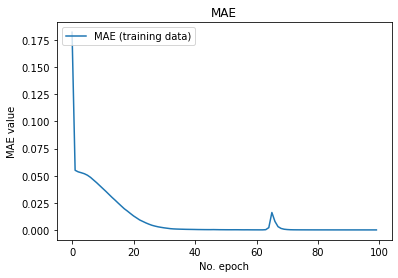

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


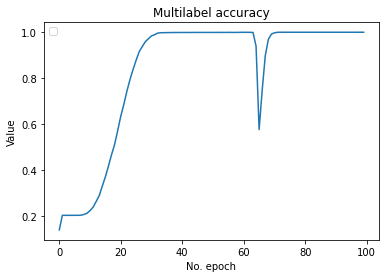

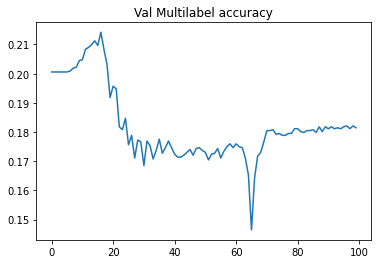

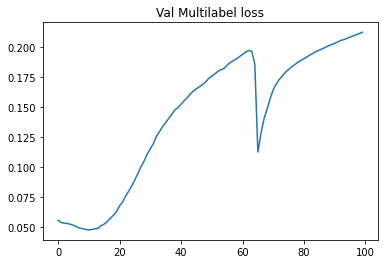

In [19]:
y_pred = predict_using_model(model,threshold=1)

print('Hamming loss : {}'.format(hamming_loss(y_test,y_pred)))
print('Accuracy : {}'.format(accuracy_score(y_test,y_pred)))

plot_loss(history)
plt.title("Val Multilabel accuracy")
plt.plot(history.history['val_multilabel_accuracy'])
plt.show()

plt.title("Val Multilabel loss")
plt.plot(history.history['val_loss'])
plt.show()